# About the code
This code is going to be the main to collect and create analysis output to answer the question "Quantifying political stance of Japanese Diet members regards specific political topics through the use of LLMs and statistical methods." (Tentative) 

## Part 1: Procedure for measuring embeddings
1. Create embeddings for each opinion-based sentence in regards to different topics and store it in a retrievable manner.
2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.
3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data
4. Collapse all the other vectors onto this axis by projecting them onto the axis
5. Create a scalar measurement for how far each politician is from the two reference points

## Part 2: Creating groups of politicians based on where their embeddings lie on an axis 
This is to get an idea of the ideas mentioned by politicians in a axis group within each topic using BERTopic. 
1. Divide politicians into n groups based on where they lie on the axis.
2. Extract opinion sentences of each group made. 
3. Run each group through topic modelling techniques.

### Notes
- Data is stored under `data/data_repr` directory
- We will attempt the procedure with different models to seek the best output

In [1]:
import os
from sentence_transformers import models, SentenceTransformer
import h5py
import numpy as np
import torch
from params.paths import ROOT_DIR
import japanize_matplotlib 
import matplotlib.pyplot as plt
from logger.Logger import Logger
from file_handling.file_read_writer import read_json, write_json, create_dir, write_file, read_hdf5_file

VERBOSE = True
logger = Logger(verbose=VERBOSE)
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_REPR_SPEECHES_DIR = os.path.join(DATA_DIR, 'data_repr')
PARTIES = [party for party in os.listdir(DATA_REPR_SPEECHES_DIR) if not '.' in party]
PARTY_TO_COLOR = {
	'自民': 'black',
	'国民': 'blue',
	'立憲': 'orange',
	'公明': 'lightblue',
	'共産': 'red',
	'維新': 'gold',
	'れ新': 'green',
	'無': 'purple',
	'有志': 'grey'
}
PARTY_TO_IDX = {party: idx for idx, party in enumerate(PARTIES)}
IDX_TO_PARTY = {idx: party for idx, party in enumerate(PARTIES)}
if len(PARTIES) != len(PARTY_TO_COLOR):
	raise ValueError('PARTIES and PARTY_TO_COLOR must have the same length.')
MODEL_NAME = "cl-tohoku/bert-base-japanese-v3"
print('-----------------------------------')
print('DATA_DIR: ', DATA_DIR)
print('DATA_REPR_SPEECHES_DIR: ', DATA_REPR_SPEECHES_DIR)
print('PARTIES: ', PARTIES)
print('-----------------------------------')

/Users/annabellepurnomo/miniforge3/envs/torch-nightly/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----------------------------------
DATA_DIR:  /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data
DATA_REPR_SPEECHES_DIR:  /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr
PARTIES:  ['公明', '立憲', '有志', '共産', '維新', 'れ新', '自民', '無', '国民']
-----------------------------------


In [2]:
# adapted from: https://osima.jp/posts/sentence-bert/

sentence_transformer = models.Transformer(MODEL_NAME)

pooling = models.Pooling(
    sentence_transformer.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=False,
    pooling_mode_cls_token=True,
    pooling_mode_max_tokens=False)

st = SentenceTransformer(modules=[sentence_transformer, pooling])

## 1. Creating the embeddings for each opinion-based sentence

In [3]:
def embed_speeches(speeches):
	encoded_opinions = st.encode(speeches, convert_to_tensor=True, show_progress_bar=True)
	return encoded_opinions

def read_opinion_sentences_and_dates(file_path):
	logger.message(f'Reading {file_path}')
	target_dict = read_json(file_path)
	opinion_sentences = []
	dates = []
	for speech in target_dict['speeches']:
		date = [speech['date'] for _ in range(len(speech['extracted_opinions']))]
		opinions = speech['extracted_opinions']
		opinion_sentences.extend(opinions)
		dates.extend(date)
	
	return opinion_sentences, dates

def iterate_topics_for_repr(repr_path, topics=[]):
	for topic in os.listdir(repr_path):
		if topic not in topics and topics:
			continue
		logger.message(f'Working on {topic}')
		topic_path = os.path.join(repr_path, topic)
		if os.path.exists(os.path.join(topic_path, 'embeddings.hdf5')):
			logger.message(f'Embeddings already exist for {topic} in {repr_path}')
			continue
		file_paths = [os.path.join(topic_path, file) for file in os.listdir(topic_path) if file.endswith('.json')]
		topic_opinions = []
		topic_dates = []
		for file_path in file_paths:
			opinion_sentences, dates = read_opinion_sentences_and_dates(file_path)
			topic_opinions.extend(opinion_sentences)
			topic_dates.extend(dates)
		embeddings = embed_speeches(topic_opinions)
		embeddings = [embedding.cpu() for embedding in embeddings]
		logger.message(f'Number of dates {len(topic_dates)}\nNumber of opinions {len(topic_opinions)} \nNumber of embeddings {len(embeddings)}')
		embeddings = torch.stack(embeddings)
		with h5py.File(os.path.join(topic_path, 'embeddings.hdf5'), 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('dates', data=topic_dates, dtype=h5py.string_dtype(encoding='utf-8'))
			f.create_dataset('opinions', data=topic_opinions, dtype=h5py.string_dtype(encoding='utf-8'))

TOPICS_TO_CREATE_EMBEDDINGS = ['防衛予算', 'エネルギー', '消費税', '移民', '原発','国債']
for party in PARTIES:
	party_path = os.path.join(DATA_REPR_SPEECHES_DIR, party)
	repr_names = os.listdir(party_path)
	for repr_name in repr_names:
		logger.message(f'{party} ----- {repr_name}')
		repr_path = os.path.join(party_path, repr_name)
		iterate_topics_for_repr(repr_path, topics=TOPICS_TO_CREATE_EMBEDDINGS)

--------------------------
公明 ----- 斉藤鉄夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/斉藤鉄夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 8/8 [00:52<00:00,  6.54s/it]


--------------------------
Number of dates 227
Number of opinions 227 
Number of embeddings 227
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/斉藤鉄夫/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
公明 ----- 佐藤茂樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/佐藤茂樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:32<00:00, 16.29s/it]


--------------------------
Number of dates 42
Number of opinions 42 
Number of embeddings 42
--------------------------
--------------------------
公明 ----- 浮島智子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/浮島智子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:14<00:00, 14.75s/it]


--------------------------
Number of dates 32
Number of opinions 32 
Number of embeddings 32
--------------------------
--------------------------
公明 ----- 佐藤英道
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/佐藤英道/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:15<00:00,  7.54s/it]


--------------------------
Number of dates 33
Number of opinions 33 
Number of embeddings 33
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/佐藤英道/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
公明 ----- 日下正喜
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/日下正喜/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/日下正喜/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
公明 ----- 吉田宣弘
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/吉田宣弘/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.33s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
公明 ----- 福重隆浩
--------------------------
--------------------------
公明 ----- 吉田久美子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/吉田久美子/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:31<00:00, 15.90s/it]


--------------------------
Number of dates 46
Number of opinions 46 
Number of embeddings 46
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/吉田久美子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
公明 ----- 岡本三成
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/岡本三成/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:20<00:00, 10.10s/it]


--------------------------
Number of dates 57
Number of opinions 57 
Number of embeddings 57
--------------------------
--------------------------
公明 ----- 輿水恵一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/輿水恵一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.96s/it]


--------------------------
Number of dates 20
Number of opinions 20 
Number of embeddings 20
--------------------------
--------------------------
公明 ----- 角田秀穂
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/角田秀穂/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.45s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
公明 ----- 河西宏一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/河西宏一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
公明 ----- 國重徹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/國重徹/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:12<00:00,  6.25s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/國重徹/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.15s/it]


--------------------------
Number of dates 27
Number of opinions 27 
Number of embeddings 27
--------------------------
--------------------------
公明 ----- 大口善徳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/大口善徳/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:39<00:00,  9.85s/it]


--------------------------
Number of dates 101
Number of opinions 101 
Number of embeddings 101
--------------------------
--------------------------
公明 ----- 浜地雅一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/浜地雅一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.30s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
公明 ----- 金城泰邦
--------------------------
--------------------------
公明 ----- 石井啓一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/石井啓一/少子化/1.json
--------------------------


Batches: 100%|██████████| 13/13 [01:22<00:00,  6.32s/it]


--------------------------
Number of dates 388
Number of opinions 388 
Number of embeddings 388
--------------------------
--------------------------
公明 ----- 鰐淵洋子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/鰐淵洋子/少子化/1.json
--------------------------


Batches: 100%|██████████| 6/6 [01:16<00:00, 12.73s/it]


--------------------------
Number of dates 192
Number of opinions 192 
Number of embeddings 192
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/鰐淵洋子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


--------------------------
Number of dates 26
Number of opinions 26 
Number of embeddings 26
--------------------------
--------------------------
公明 ----- 竹内譲
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/竹内譲/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:23<00:00,  7.95s/it]


--------------------------
Number of dates 80
Number of opinions 80 
Number of embeddings 80
--------------------------
--------------------------
公明 ----- 中野洋昌
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/中野洋昌/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:37<00:00, 12.49s/it]


--------------------------
Number of dates 82
Number of opinions 82 
Number of embeddings 82
--------------------------
--------------------------
公明 ----- 中川康洋
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/中川康洋/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
公明 ----- 庄子賢一
--------------------------
--------------------------
公明 ----- 赤羽一嘉
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/赤羽一嘉/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:26<00:00, 13.32s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
公明 ----- 伊佐進一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/伊佐進一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:18<00:00, 18.23s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
公明 ----- 稲津久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/稲津久/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:15<00:00, 15.05s/it]


--------------------------
Number of dates 24
Number of opinions 24 
Number of embeddings 24
--------------------------
--------------------------
公明 ----- 平林晃
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/平林晃/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.76s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
公明 ----- 高木陽介
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/高木陽介/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.74s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
公明 ----- 中川宏昌
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/中川宏昌/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
公明 ----- 山崎正恭
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/山崎正恭/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:18<00:00, 18.04s/it]


--------------------------
Number of dates 21
Number of opinions 21 
Number of embeddings 21
--------------------------
--------------------------
公明 ----- 古屋範子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/古屋範子/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/古屋範子/少子化/2.json
--------------------------


Batches: 100%|██████████| 10/10 [01:08<00:00,  6.90s/it]


--------------------------
Number of dates 306
Number of opinions 306 
Number of embeddings 306
--------------------------
--------------------------
公明 ----- 伊藤渉
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/伊藤渉/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:29<00:00, 14.87s/it]


--------------------------
Number of dates 42
Number of opinions 42 
Number of embeddings 42
--------------------------
--------------------------
公明 ----- 北側一雄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/公明/北側一雄/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:42<00:00, 10.68s/it]


--------------------------
Number of dates 114
Number of opinions 114 
Number of embeddings 114
--------------------------
--------------------------
立憲 ----- 玄葉光一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/玄葉光一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:20<00:00, 20.30s/it]


--------------------------
Number of dates 27
Number of opinions 27 
Number of embeddings 27
--------------------------
--------------------------
立憲 ----- 白石洋一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/白石洋一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
立憲 ----- 大串博志
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大串博志/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:13<00:00, 13.21s/it]


--------------------------
Number of dates 26
Number of opinions 26 
Number of embeddings 26
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大串博志/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
立憲 ----- 牧義夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/牧義夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:26<00:00, 13.42s/it]


--------------------------
Number of dates 56
Number of opinions 56 
Number of embeddings 56
--------------------------
--------------------------
立憲 ----- 岡田克也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/岡田克也/少子化/1.json
--------------------------


Batches: 100%|██████████| 10/10 [00:56<00:00,  5.60s/it]


--------------------------
Number of dates 294
Number of opinions 294 
Number of embeddings 294
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/岡田克也/LGBT/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:12<00:00,  4.22s/it]


--------------------------
Number of dates 71
Number of opinions 71 
Number of embeddings 71
--------------------------
--------------------------
立憲 ----- 岡本あき子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/岡本あき子/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:18<00:00,  9.07s/it]


--------------------------
Number of dates 42
Number of opinions 42 
Number of embeddings 42
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/岡本あき子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
立憲 ----- 梅谷守
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/梅谷守/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
立憲 ----- 江田憲司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/江田憲司/少子化/1.json
--------------------------


Batches: 100%|██████████| 5/5 [00:35<00:00,  7.07s/it]


--------------------------
Number of dates 137
Number of opinions 137 
Number of embeddings 137
--------------------------
--------------------------
立憲 ----- 谷田川元
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/谷田川元/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
立憲 ----- 大河原まさこ
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大河原まさこ/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:22<00:00,  7.61s/it]


--------------------------
Number of dates 68
Number of opinions 68 
Number of embeddings 68
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大河原まさこ/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
立憲 ----- 小熊慎司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/小熊慎司/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:46<00:00, 15.46s/it]


--------------------------
Number of dates 78
Number of opinions 78 
Number of embeddings 78
--------------------------
--------------------------
立憲 ----- 中谷一馬
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/中谷一馬/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:27<00:00, 13.99s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/中谷一馬/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
立憲 ----- 緑川貴士
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/緑川貴士/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:32<00:00, 16.02s/it]


--------------------------
Number of dates 54
Number of opinions 54 
Number of embeddings 54
--------------------------
--------------------------
立憲 ----- 野間健
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/野間健/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:30<00:00, 15.18s/it]


--------------------------
Number of dates 49
Number of opinions 49 
Number of embeddings 49
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/野間健/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:12<00:00,  6.04s/it]


--------------------------
Number of dates 41
Number of opinions 41 
Number of embeddings 41
--------------------------
--------------------------
立憲 ----- 山崎誠
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山崎誠/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.11s/it]


--------------------------
Number of dates 23
Number of opinions 23 
Number of embeddings 23
--------------------------
--------------------------
立憲 ----- 重徳和彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/重徳和彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 8/8 [01:30<00:00, 11.32s/it]


--------------------------
Number of dates 237
Number of opinions 237 
Number of embeddings 237
--------------------------
--------------------------
立憲 ----- 城井崇
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/城井崇/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:19<00:00,  9.68s/it]


--------------------------
Number of dates 62
Number of opinions 62 
Number of embeddings 62
--------------------------
--------------------------
立憲 ----- 吉田はるみ
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/吉田はるみ/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/吉田はるみ/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:18<00:00,  9.40s/it]


--------------------------
Number of dates 63
Number of opinions 63 
Number of embeddings 63
--------------------------
--------------------------
立憲 ----- 馬淵澄夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/馬淵澄夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
立憲 ----- 後藤祐一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/後藤祐一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.17s/it]


--------------------------
Number of dates 24
Number of opinions 24 
Number of embeddings 24
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/後藤祐一/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
立憲 ----- おおつき紅葉
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/おおつき紅葉/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:20<00:00,  6.70s/it]


--------------------------
Number of dates 75
Number of opinions 75 
Number of embeddings 75
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/おおつき紅葉/LGBT/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:16<00:00,  5.63s/it]


--------------------------
Number of dates 73
Number of opinions 73 
Number of embeddings 73
--------------------------
--------------------------
立憲 ----- 篠原豪
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/篠原豪/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.50s/it]


--------------------------
Number of dates 27
Number of opinions 27 
Number of embeddings 27
--------------------------
--------------------------
立憲 ----- 金子恵美
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/金子恵美/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/金子恵美/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
立憲 ----- 渡辺周
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/渡辺周/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:24<00:00, 12.17s/it]


--------------------------
Number of dates 59
Number of opinions 59 
Number of embeddings 59
--------------------------
--------------------------
立憲 ----- 松原仁
--------------------------
--------------------------
立憲 ----- 坂本祐之輔
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/坂本祐之輔/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:23<00:00,  7.68s/it]


--------------------------
Number of dates 66
Number of opinions 66 
Number of embeddings 66
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/坂本祐之輔/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


--------------------------
Number of dates 22
Number of opinions 22 
Number of embeddings 22
--------------------------
--------------------------
立憲 ----- 柚木道義
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/柚木道義/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:52<00:00, 13.25s/it]


--------------------------
Number of dates 110
Number of opinions 110 
Number of embeddings 110
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/柚木道義/LGBT/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:30<00:00, 10.23s/it]


--------------------------
Number of dates 84
Number of opinions 84 
Number of embeddings 84
--------------------------
--------------------------
立憲 ----- 小宮山泰子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/小宮山泰子/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:16<00:00,  8.27s/it]


--------------------------
Number of dates 44
Number of opinions 44 
Number of embeddings 44
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/小宮山泰子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.94s/it]


--------------------------
Number of dates 17
Number of opinions 17 
Number of embeddings 17
--------------------------
--------------------------
立憲 ----- 堤かなめ
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/堤かなめ/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:25<00:00,  8.52s/it]


--------------------------
Number of dates 67
Number of opinions 67 
Number of embeddings 67
--------------------------
--------------------------
立憲 ----- 大西健介
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大西健介/少子化/1.json
--------------------------


Batches: 100%|██████████| 5/5 [00:55<00:00, 11.12s/it]


--------------------------
Number of dates 147
Number of opinions 147 
Number of embeddings 147
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大西健介/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
立憲 ----- 近藤昭一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/近藤昭一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.08s/it]


--------------------------
Number of dates 19
Number of opinions 19 
Number of embeddings 19
--------------------------
--------------------------
立憲 ----- 落合貴之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/落合貴之/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.24s/it]


--------------------------
Number of dates 17
Number of opinions 17 
Number of embeddings 17
--------------------------
--------------------------
立憲 ----- 下条みつ
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/下条みつ/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:24<00:00,  8.32s/it]


--------------------------
Number of dates 66
Number of opinions 66 
Number of embeddings 66
--------------------------
--------------------------
立憲 ----- 西村智奈美
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/西村智奈美/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:33<00:00, 11.31s/it]


--------------------------
Number of dates 96
Number of opinions 96 
Number of embeddings 96
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/西村智奈美/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:17<00:00, 17.79s/it]


--------------------------
Number of dates 29
Number of opinions 29 
Number of embeddings 29
--------------------------
--------------------------
立憲 ----- 井坂信彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/井坂信彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:29<00:00,  9.71s/it]


--------------------------
Number of dates 76
Number of opinions 76 
Number of embeddings 76
--------------------------
--------------------------
立憲 ----- 伴野豊
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/伴野豊/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
立憲 ----- 泉健太
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/泉健太/少子化/1.json
--------------------------


Batches: 100%|██████████| 17/17 [01:39<00:00,  5.87s/it]


--------------------------
Number of dates 522
Number of opinions 522 
Number of embeddings 522
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/泉健太/LGBT/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:21<00:00,  7.32s/it]


--------------------------
Number of dates 80
Number of opinions 80 
Number of embeddings 80
--------------------------
--------------------------
立憲 ----- 吉田統彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/吉田統彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:14<00:00,  7.19s/it]


--------------------------
Number of dates 35
Number of opinions 35 
Number of embeddings 35
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/吉田統彦/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
立憲 ----- 福田昭夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/福田昭夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:27<00:00,  9.04s/it]


--------------------------
Number of dates 89
Number of opinions 89 
Number of embeddings 89
--------------------------
--------------------------
立憲 ----- 田嶋要
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/田嶋要/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:20<00:00, 10.49s/it]


--------------------------
Number of dates 53
Number of opinions 53 
Number of embeddings 53
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/田嶋要/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
立憲 ----- 小川淳也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/小川淳也/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:28<00:00,  7.15s/it]


--------------------------
Number of dates 113
Number of opinions 113 
Number of embeddings 113
--------------------------
--------------------------
立憲 ----- 末次精一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/末次精一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
立憲 ----- 山岸一生
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山岸一生/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山岸一生/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
立憲 ----- 小沢一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/小沢一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:21<00:00,  7.22s/it]


--------------------------
Number of dates 65
Number of opinions 65 
Number of embeddings 65
--------------------------
--------------------------
立憲 ----- 伊藤俊輔
--------------------------
--------------------------
立憲 ----- 野田佳彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/野田佳彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 10/10 [01:19<00:00,  7.93s/it]


--------------------------
Number of dates 303
Number of opinions 303 
Number of embeddings 303
--------------------------
--------------------------
立憲 ----- 石川香織
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/石川香織/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:13<00:00,  6.68s/it]


--------------------------
Number of dates 47
Number of opinions 47 
Number of embeddings 47
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/石川香織/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


--------------------------
Number of dates 41
Number of opinions 41 
Number of embeddings 41
--------------------------
--------------------------
立憲 ----- 篠原孝
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/篠原孝/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]


--------------------------
Number of dates 40
Number of opinions 40 
Number of embeddings 40
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/篠原孝/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:17<00:00,  8.59s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
立憲 ----- 菅直人
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/菅直人/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/菅直人/少子化/2.json
--------------------------


Batches: 100%|██████████| 20/20 [02:24<00:00,  7.25s/it]


--------------------------
Number of dates 632
Number of opinions 632 
Number of embeddings 632
--------------------------
--------------------------
立憲 ----- 湯原俊二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/湯原俊二/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/湯原俊二/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
立憲 ----- 吉川元
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/吉川元/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:18<00:00,  9.37s/it]


--------------------------
Number of dates 46
Number of opinions 46 
Number of embeddings 46
--------------------------
--------------------------
立憲 ----- 藤岡隆雄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/藤岡隆雄/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.51s/it]


--------------------------
Number of dates 17
Number of opinions 17 
Number of embeddings 17
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/藤岡隆雄/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
立憲 ----- 山井和則
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山井和則/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:43<00:00, 10.98s/it]


--------------------------
Number of dates 115
Number of opinions 115 
Number of embeddings 115
--------------------------
--------------------------
立憲 ----- 稲富修二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/稲富修二/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:14<00:00,  7.11s/it]


--------------------------
Number of dates 53
Number of opinions 53 
Number of embeddings 53
--------------------------
--------------------------
立憲 ----- 大島敦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/大島敦/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.87s/it]


--------------------------
Number of dates 36
Number of opinions 36 
Number of embeddings 36
--------------------------
--------------------------
立憲 ----- 太栄志
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/太栄志/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
立憲 ----- 渡辺創
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/渡辺創/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
立憲 ----- 森山浩行
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/森山浩行/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.79s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/森山浩行/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
立憲 ----- 長妻昭
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/長妻昭/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/長妻昭/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/長妻昭/少子化/3.json
--------------------------


Batches: 100%|██████████| 12/12 [01:47<00:00,  8.96s/it]


--------------------------
Number of dates 358
Number of opinions 358 
Number of embeddings 358
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/長妻昭/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
立憲 ----- 鈴木庸介
--------------------------
--------------------------
立憲 ----- 神津たけし
--------------------------
--------------------------
立憲 ----- 菊田真紀子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/菊田真紀子/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:33<00:00, 11.07s/it]


--------------------------
Number of dates 85
Number of opinions 85 
Number of embeddings 85
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/菊田真紀子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
立憲 ----- 鎌田さゆり
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/鎌田さゆり/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:28<00:00, 14.22s/it]


--------------------------
Number of dates 40
Number of opinions 40 
Number of embeddings 40
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/鎌田さゆり/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.01s/it]


--------------------------
Number of dates 15
Number of opinions 15 
Number of embeddings 15
--------------------------
--------------------------
立憲 ----- 新垣邦男
--------------------------
--------------------------
立憲 ----- 青山大人
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/青山大人/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.16s/it]


--------------------------
Number of dates 20
Number of opinions 20 
Number of embeddings 20
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/青山大人/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
立憲 ----- 安住淳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/安住淳/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:45<00:00, 11.43s/it]


--------------------------
Number of dates 117
Number of opinions 117 
Number of embeddings 117
--------------------------
--------------------------
立憲 ----- 米山隆一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/米山隆一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/米山隆一/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.11s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
立憲 ----- 近藤和也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/近藤和也/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.46s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
立憲 ----- 逢坂誠二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/逢坂誠二/少子化/1.json
--------------------------


Batches: 100%|██████████| 8/8 [06:23<00:00, 47.97s/it] 


--------------------------
Number of dates 236
Number of opinions 236 
Number of embeddings 236
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/逢坂誠二/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
立憲 ----- 阿部知子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/阿部知子/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/阿部知子/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/阿部知子/少子化/3.json
--------------------------


Batches: 100%|██████████| 14/14 [01:53<00:00,  8.08s/it]


--------------------------
Number of dates 442
Number of opinions 442 
Number of embeddings 442
--------------------------
--------------------------
立憲 ----- 中島克仁
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/中島克仁/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:27<00:00,  9.24s/it]


--------------------------
Number of dates 72
Number of opinions 72 
Number of embeddings 72
--------------------------
--------------------------
有志 ----- 緒方林太郎
--------------------------
--------------------------
Working on 移民
--------------------------
--------------------------
Embeddings already exist for 移民 in /root/projects/kokkai_analysis/data_prepping/params/../data/data_repr/有志/緒方林太郎
--------------------------
--------------------------
Working on 消費税
--------------------------
--------------------------
Embeddings already exist for 消費税 in /root/projects/kokkai_analysis/data_prepping/params/../data/data_repr/有志/緒方林太郎
--------------------------
--------------------------
Working on エネルギー
--------------------------
--------------------------
Embeddings already exist for エネルギー in /root/projects/kokkai_analysis/data_prepping/params/../data/data_repr/有志/緒方林太郎
--------------------------
--------------------------
Working on 防衛予算
--------------------------
-------------------------

Batches: 100%|██████████| 1/1 [00:09<00:00,  9.50s/it]


--------------------------
Number of dates 19
Number of opinions 19 
Number of embeddings 19
--------------------------
--------------------------
立憲 ----- 森田俊和
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/森田俊和/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:14<00:00, 14.04s/it]


--------------------------
Number of dates 13
Number of opinions 13 
Number of embeddings 13
--------------------------
--------------------------
立憲 ----- 佐藤公治
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/佐藤公治/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:38<00:00, 12.73s/it]


--------------------------
Number of dates 82
Number of opinions 82 
Number of embeddings 82
--------------------------
--------------------------
立憲 ----- 青柳陽一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/青柳陽一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


--------------------------
Number of dates 17
Number of opinions 17 
Number of embeddings 17
--------------------------
--------------------------
立憲 ----- 枝野幸男
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/枝野幸男/少子化/1.json
--------------------------


Batches: 100%|██████████| 26/26 [03:11<00:00,  7.35s/it]


--------------------------
Number of dates 810
Number of opinions 810 
Number of embeddings 810
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/枝野幸男/LGBT/1.json
--------------------------


Batches: 100%|██████████| 18/18 [01:46<00:00,  5.91s/it]


--------------------------
Number of dates 562
Number of opinions 562 
Number of embeddings 562
--------------------------
--------------------------
立憲 ----- 小山展弘
--------------------------
--------------------------
立憲 ----- 奥野総一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/奥野総一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/奥野総一郎/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
立憲 ----- 中村喜四郎
--------------------------
--------------------------
立憲 ----- 手塚仁雄
--------------------------
--------------------------
立憲 ----- 階猛
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/階猛/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:24<00:00,  8.04s/it]


--------------------------
Number of dates 86
Number of opinions 86 
Number of embeddings 86
--------------------------
--------------------------
立憲 ----- 徳永久志
--------------------------
--------------------------
立憲 ----- 松木けんこう
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/松木けんこう/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
立憲 ----- 櫻井周
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/櫻井周/少子化/1.json
--------------------------


Batches: 100%|██████████| 6/6 [00:52<00:00,  8.70s/it]


--------------------------
Number of dates 191
Number of opinions 191 
Number of embeddings 191
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/櫻井周/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.55s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
立憲 ----- 早稲田ゆき
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/早稲田ゆき/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:30<00:00, 10.01s/it]


--------------------------
Number of dates 82
Number of opinions 82 
Number of embeddings 82
--------------------------
--------------------------
立憲 ----- 道下大樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/道下大樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.54s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/道下大樹/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:22<00:00, 11.10s/it]


--------------------------
Number of dates 36
Number of opinions 36 
Number of embeddings 36
--------------------------
--------------------------
立憲 ----- 山田勝彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山田勝彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山田勝彦/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
立憲 ----- 神谷裕
--------------------------
--------------------------
立憲 ----- 中川正春
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/中川正春/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:38<00:00,  9.65s/it]


--------------------------
Number of dates 100
Number of opinions 100 
Number of embeddings 100
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/中川正春/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.09s/it]


--------------------------
Number of dates 26
Number of opinions 26 
Number of embeddings 26
--------------------------
--------------------------
立憲 ----- 山岡達丸
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/山岡達丸/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
立憲 ----- 馬場雄基
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/馬場雄基/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:12<00:00,  6.39s/it]


--------------------------
Number of dates 42
Number of opinions 42 
Number of embeddings 42
--------------------------
--------------------------
立憲 ----- 荒井優
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/荒井優/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.52s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/荒井優/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.95s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
立憲 ----- 源馬謙太郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/源馬謙太郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:24<00:00,  8.32s/it]


--------------------------
Number of dates 65
Number of opinions 65 
Number of embeddings 65
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/源馬謙太郎/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
立憲 ----- 本庄知史
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/本庄知史/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
立憲 ----- 原口一博
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/原口一博/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]


--------------------------
Number of dates 20
Number of opinions 20 
Number of embeddings 20
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/原口一博/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:08<00:00,  4.40s/it]


--------------------------
Number of dates 47
Number of opinions 47 
Number of embeddings 47
--------------------------
--------------------------
立憲 ----- 末松義規
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/末松義規/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


--------------------------
Number of dates 21
Number of opinions 21 
Number of embeddings 21
--------------------------
--------------------------
立憲 ----- 笠浩史
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/立憲/笠浩史/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.41s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
有志 ----- 緒方林太郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/緒方林太郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:33<00:00, 16.98s/it]


--------------------------
Number of dates 62
Number of opinions 62 
Number of embeddings 62
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/緒方林太郎
--------------------------
--------------------------
有志 ----- 北神圭朗
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/北神圭朗/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.69s/it]


--------------------------
Number of dates 35
Number of opinions 35 
Number of embeddings 35
--------------------------
--------------------------
有志 ----- 仁木博文
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/仁木博文/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:21<00:00, 21.86s/it]


--------------------------
Number of dates 26
Number of opinions 26 
Number of embeddings 26
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/仁木博文
--------------------------
--------------------------
有志 ----- 福島伸享
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/福島伸享/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
有志 ----- 吉良州司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/有志/吉良州司/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:25<00:00, 12.80s/it]


--------------------------
Number of dates 56
Number of opinions 56 
Number of embeddings 56
--------------------------
--------------------------
共産 ----- 本村伸子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/本村伸子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/本村伸子
--------------------------
--------------------------
共産 ----- 穀田恵二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/穀田恵二/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:16<00:00,  8.09s/it]


--------------------------
Number of dates 52
Number of opinions 52 
Number of embeddings 52
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/穀田恵二
--------------------------
--------------------------
共産 ----- 宮本岳志
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/宮本岳志/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:22<00:00, 11.45s/it]


--------------------------
Number of dates 48
Number of opinions 48 
Number of embeddings 48
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/宮本岳志
--------------------------
--------------------------
共産 ----- 田村貴昭
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/田村貴昭/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:13<00:00, 13.20s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/田村貴昭
--------------------------
--------------------------
共産 ----- 宮本徹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/宮本徹/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:28<00:00,  7.15s/it]


--------------------------
Number of dates 123
Number of opinions 123 
Number of embeddings 123
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/宮本徹
--------------------------
--------------------------
共産 ----- 塩川鉄也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/塩川鉄也/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.84s/it]


--------------------------
Number of dates 28
Number of opinions 28 
Number of embeddings 28
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/塩川鉄也
--------------------------
--------------------------
共産 ----- 高橋千鶴子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/高橋千鶴子/少子化/1.json
--------------------------


Batches: 100%|██████████| 6/6 [00:40<00:00,  6.73s/it]


--------------------------
Number of dates 178
Number of opinions 178 
Number of embeddings 178
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/高橋千鶴子
--------------------------
--------------------------
共産 ----- 赤嶺政賢
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/赤嶺政賢
--------------------------
--------------------------
共産 ----- 志位和夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/志位和夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


--------------------------
Number of dates 21
Number of opinions 21 
Number of embeddings 21
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/志位和夫
--------------------------
--------------------------
共産 ----- 笠井亮
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/共産/笠井亮/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.50s/it]


--------------------------
Number of dates 24
Number of opinions 24 
Number of embeddings 24
--------------------------
--------------------------
維新 ----- 前川清成
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/前川清成/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
維新 ----- 守島正
--------------------------
--------------------------
維新 ----- 足立康史
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/足立康史/少子化/1.json
--------------------------


Batches: 100%|██████████| 6/6 [00:51<00:00,  8.65s/it]


--------------------------
Number of dates 184
Number of opinions 184 
Number of embeddings 184
--------------------------
--------------------------
維新 ----- 岬麻紀
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/岬麻紀/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:22<00:00, 11.26s/it]


--------------------------
Number of dates 42
Number of opinions 42 
Number of embeddings 42
--------------------------
--------------------------
維新 ----- 岩谷良平
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/岩谷良平/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.93s/it]


--------------------------
Number of dates 15
Number of opinions 15 
Number of embeddings 15
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/岩谷良平
--------------------------
--------------------------
維新 ----- 遠藤良太
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/遠藤良太/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
維新 ----- 住吉寛紀
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/住吉寛紀/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:32<00:00, 10.67s/it]


--------------------------
Number of dates 92
Number of opinions 92 
Number of embeddings 92
--------------------------
--------------------------
維新 ----- 池下卓
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/池下卓/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:24<00:00, 12.22s/it]


--------------------------
Number of dates 44
Number of opinions 44 
Number of embeddings 44
--------------------------
--------------------------
維新 ----- 阿部弘樹
--------------------------
--------------------------
維新 ----- 山本剛正
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/山本剛正/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it]


--------------------------
Number of dates 21
Number of opinions 21 
Number of embeddings 21
--------------------------
--------------------------
維新 ----- 堀場幸子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/堀場幸子/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:39<00:00,  9.76s/it]


--------------------------
Number of dates 118
Number of opinions 118 
Number of embeddings 118
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/堀場幸子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:22<00:00, 11.06s/it]


--------------------------
Number of dates 39
Number of opinions 39 
Number of embeddings 39
--------------------------
--------------------------
維新 ----- 馬場伸幸
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/馬場伸幸/少子化/1.json
--------------------------


Batches: 100%|██████████| 7/7 [00:57<00:00,  8.28s/it]


--------------------------
Number of dates 223
Number of opinions 223 
Number of embeddings 223
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/馬場伸幸/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.72s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
維新 ----- 金村龍那
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/金村龍那/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:23<00:00,  7.79s/it]


--------------------------
Number of dates 67
Number of opinions 67 
Number of embeddings 67
--------------------------
--------------------------
維新 ----- 浅川義治
--------------------------
--------------------------
維新 ----- 井上英孝
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/井上英孝/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:30<00:00, 15.25s/it]


--------------------------
Number of dates 47
Number of opinions 47 
Number of embeddings 47
--------------------------
--------------------------
維新 ----- 和田有一朗
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/和田有一朗/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.78s/it]


--------------------------
Number of dates 27
Number of opinions 27 
Number of embeddings 27
--------------------------
--------------------------
維新 ----- 浦野靖人
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/浦野靖人/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:27<00:00,  9.12s/it]


--------------------------
Number of dates 87
Number of opinions 87 
Number of embeddings 87
--------------------------
--------------------------
維新 ----- 掘井健智
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/掘井健智/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.26s/it]


--------------------------
Number of dates 13
Number of opinions 13 
Number of embeddings 13
--------------------------
--------------------------
維新 ----- 奥下剛光
--------------------------
--------------------------
維新 ----- 赤木正幸
--------------------------
--------------------------
維新 ----- 早坂敦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/早坂敦/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
維新 ----- 吉田とも代
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/吉田とも代/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:14<00:00,  7.18s/it]


--------------------------
Number of dates 36
Number of opinions 36 
Number of embeddings 36
--------------------------
--------------------------
維新 ----- 杉本和巳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/杉本和巳/少子化/1.json
--------------------------


Batches: 100%|██████████| 5/5 [01:13<00:00, 14.66s/it]


--------------------------
Number of dates 140
Number of opinions 140 
Number of embeddings 140
--------------------------
--------------------------
維新 ----- 中司宏
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/中司宏/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.50s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
維新 ----- 沢田良
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/沢田良/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.32s/it]


--------------------------
Number of dates 27
Number of opinions 27 
Number of embeddings 27
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/沢田良/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
維新 ----- 高橋英明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/高橋英明/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
維新 ----- 藤巻健太
--------------------------
--------------------------
維新 ----- 空本誠喜
--------------------------
--------------------------
維新 ----- 美延映夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/美延映夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]


--------------------------
Number of dates 13
Number of opinions 13 
Number of embeddings 13
--------------------------
--------------------------
維新 ----- 阿部司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/阿部司/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:28<00:00, 14.20s/it]


--------------------------
Number of dates 63
Number of opinions 63 
Number of embeddings 63
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/阿部司/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
維新 ----- 伊東信久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/伊東信久/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:24<00:00, 12.11s/it]


--------------------------
Number of dates 56
Number of opinions 56 
Number of embeddings 56
--------------------------
--------------------------
維新 ----- 市村浩一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/市村浩一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:21<00:00, 21.23s/it]


--------------------------
Number of dates 28
Number of opinions 28 
Number of embeddings 28
--------------------------
--------------------------
維新 ----- 遠藤敬
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/遠藤敬/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:15<00:00, 15.17s/it]


--------------------------
Number of dates 29
Number of opinions 29 
Number of embeddings 29
--------------------------
--------------------------
維新 ----- 藤田文武
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/藤田文武/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:12<00:00,  6.42s/it]


--------------------------
Number of dates 36
Number of opinions 36 
Number of embeddings 36
--------------------------
--------------------------
維新 ----- 三木圭恵
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/三木圭恵/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.32s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
維新 ----- 小野泰輔
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/小野泰輔/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.34s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
維新 ----- 漆間譲司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/漆間譲司/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.90s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
維新 ----- 一谷勇一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/一谷勇一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:27<00:00, 13.52s/it]


--------------------------
Number of dates 47
Number of opinions 47 
Number of embeddings 47
--------------------------
--------------------------
維新 ----- 青柳仁士
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/青柳仁士/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:14<00:00,  7.22s/it]


--------------------------
Number of dates 52
Number of opinions 52 
Number of embeddings 52
--------------------------
--------------------------
維新 ----- 池畑浩太朗
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/維新/池畑浩太朗/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
れ新 ----- 大石あきこ
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/れ新/大石あきこ/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:13<00:00, 13.88s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/れ新/大石あきこ
--------------------------
--------------------------
れ新 ----- 櫛渕万里
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/れ新/櫛渕万里/少子化/1.json
--------------------------


Batches: 100%|██████████| 5/5 [00:33<00:00,  6.71s/it]


--------------------------
Number of dates 136
Number of opinions 136 
Number of embeddings 136
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/れ新/櫛渕万里
--------------------------
--------------------------
れ新 ----- たがや亮
--------------------------
--------------------------
自民 ----- 神田憲次
--------------------------
--------------------------
自民 ----- 中谷真一
--------------------------
--------------------------
自民 ----- 細田健一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/細田健一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 谷公一
--------------------------
--------------------------
自民 ----- 熊田裕通
--------------------------
--------------------------
自民 ----- 山本有二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山本有二/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 二階俊博
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/二階俊博/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:14<00:00, 14.76s/it]


--------------------------
Number of dates 23
Number of opinions 23 
Number of embeddings 23
--------------------------
--------------------------
自民 ----- 新谷正義
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/新谷正義/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.67s/it]


--------------------------
Number of dates 23
Number of opinions 23 
Number of embeddings 23
--------------------------
--------------------------
自民 ----- 井野俊郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井野俊郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 義家弘介
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/義家弘介/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:23<00:00, 11.99s/it]


--------------------------
Number of dates 50
Number of opinions 50 
Number of embeddings 50
--------------------------
--------------------------
自民 ----- 高階恵美子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高階恵美子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 梶山弘志
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/梶山弘志/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:42<00:00, 10.57s/it]


--------------------------
Number of dates 108
Number of opinions 108 
Number of embeddings 108
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/梶山弘志/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 大岡敏孝
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/大岡敏孝/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 井上信治
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井上信治/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 石井拓
--------------------------
--------------------------
自民 ----- 小倉將信
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小倉將信/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小倉將信/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小倉將信/少子化/3.json
--------------------------


Batches: 100%|██████████| 9/9 [01:31<00:00, 10.21s/it]


--------------------------
Number of dates 270
Number of opinions 270 
Number of embeddings 270
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小倉將信/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.11s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
自民 ----- 小泉進次郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小泉進次郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.53s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小泉進次郎/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 金子恭之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/金子恭之/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 山口俊一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山口俊一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.45s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 船田元
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/船田元/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.63s/it]


--------------------------
Number of dates 23
Number of opinions 23 
Number of embeddings 23
--------------------------
--------------------------
自民 ----- 大西英男
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/大西英男/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.60s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
自民 ----- 大串正樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/大串正樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 井林辰憲
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井林辰憲/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 林幹雄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/林幹雄/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.26s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 土屋品子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/土屋品子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.77s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 五十嵐清
--------------------------
--------------------------
自民 ----- 石原正敬
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/石原正敬/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 木原稔
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/木原稔/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.37s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
自民 ----- 山下貴司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山下貴司/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山下貴司/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 宮下一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/宮下一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/宮下一郎/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 伊藤信太郎
--------------------------
--------------------------
自民 ----- 中山展宏
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/中山展宏/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 橘慶一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/橘慶一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.49s/it]


--------------------------
Number of dates 15
Number of opinions 15 
Number of embeddings 15
--------------------------
--------------------------
自民 ----- 柴山昌彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/柴山昌彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 5/5 [01:13<00:00, 14.68s/it]


--------------------------
Number of dates 150
Number of opinions 150 
Number of embeddings 150
--------------------------
--------------------------
自民 ----- 西村康稔
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/西村康稔/少子化/1.json
--------------------------


Batches: 100%|██████████| 6/6 [00:57<00:00,  9.57s/it]


--------------------------
Number of dates 168
Number of opinions 168 
Number of embeddings 168
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/西村康稔/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
自民 ----- 田中和徳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田中和徳/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:15<00:00,  7.98s/it]


--------------------------
Number of dates 37
Number of opinions 37 
Number of embeddings 37
--------------------------
--------------------------
自民 ----- 坂本哲志
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/坂本哲志/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/坂本哲志/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/坂本哲志/少子化/3.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/坂本哲志/少子化/4.json
--------------------------


Batches: 100%|██████████| 11/11 [01:34<00:00,  8.55s/it]


--------------------------
Number of dates 322
Number of opinions 322 
Number of embeddings 322
--------------------------
--------------------------
自民 ----- 谷川とむ
--------------------------
--------------------------
自民 ----- 棚橋泰文
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/棚橋泰文/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.62s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 森山裕
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/森山裕/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 三ッ林裕巳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/三ッ林裕巳/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:31<00:00, 15.80s/it]


--------------------------
Number of dates 36
Number of opinions 36 
Number of embeddings 36
--------------------------
--------------------------
自民 ----- 松本尚
--------------------------
--------------------------
自民 ----- 簗和生
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/簗和生/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 田畑裕明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田畑裕明/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:17<00:00, 17.16s/it]


--------------------------
Number of dates 28
Number of opinions 28 
Number of embeddings 28
--------------------------
--------------------------
自民 ----- 斎藤洋明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/斎藤洋明/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 堀井学
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/堀井学/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:11<00:00, 11.44s/it]


--------------------------
Number of dates 29
Number of opinions 29 
Number of embeddings 29
--------------------------
--------------------------
自民 ----- 高木啓
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高木啓/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
自民 ----- あかま二郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/あかま二郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 高木毅
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高木毅/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 中西健治
--------------------------
--------------------------
自民 ----- 若宮健嗣
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/若宮健嗣/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/若宮健嗣/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 田野瀬太道
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田野瀬太道/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.70s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 稲田朋美
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/稲田朋美/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/稲田朋美/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.71s/it]


--------------------------
Number of dates 59
Number of opinions 59 
Number of embeddings 59
--------------------------
--------------------------
自民 ----- 務台俊介
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/務台俊介/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
自民 ----- 門山宏哲
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/門山宏哲/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 岩田和親
--------------------------
--------------------------
自民 ----- 木原誠二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/木原誠二/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.25s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
自民 ----- 田所嘉徳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田所嘉徳/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 深澤陽一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/深澤陽一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 武部新
--------------------------
--------------------------
自民 ----- 坂井学
--------------------------
--------------------------
自民 ----- 赤澤亮正
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/赤澤亮正/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:40<00:00, 20.28s/it]


--------------------------
Number of dates 63
Number of opinions 63 
Number of embeddings 63
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/赤澤亮正/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 山口晋
--------------------------
--------------------------
自民 ----- 武田良太
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/武田良太/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 中村裕之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/中村裕之/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.78s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
自民 ----- 牧原秀樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/牧原秀樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:20<00:00, 10.29s/it]


--------------------------
Number of dates 55
Number of opinions 55 
Number of embeddings 55
--------------------------
--------------------------
自民 ----- 工藤彰三
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/工藤彰三/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 保岡宏武
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/保岡宏武/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.49s/it]


--------------------------
Number of dates 22
Number of opinions 22 
Number of embeddings 22
--------------------------
--------------------------
自民 ----- 武藤容治
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/武藤容治/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 越智隆雄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/越智隆雄/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:19<00:00, 19.66s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
自民 ----- 河野太郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/河野太郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.88s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/河野太郎/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 西銘恒三郎
--------------------------
--------------------------
自民 ----- 大塚拓
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/大塚拓/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 橋本岳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/橋本岳/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:20<00:00, 20.94s/it]


--------------------------
Number of dates 25
Number of opinions 25 
Number of embeddings 25
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/橋本岳/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.75s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 黄川田仁志
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/黄川田仁志/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 小里泰弘
--------------------------
--------------------------
自民 ----- 尾身朝子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/尾身朝子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 古川直季
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/古川直季/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 本田太郎
--------------------------
--------------------------
自民 ----- 森英介
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/森英介/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:14<00:00, 14.99s/it]


--------------------------
Number of dates 20
Number of opinions 20 
Number of embeddings 20
--------------------------
--------------------------
自民 ----- 渡海紀三朗
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/渡海紀三朗/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.82s/it]


--------------------------
Number of dates 15
Number of opinions 15 
Number of embeddings 15
--------------------------
--------------------------
自民 ----- 鈴木貴子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/鈴木貴子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 平将明
--------------------------
--------------------------
自民 ----- 丹羽秀樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/丹羽秀樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.86s/it]


--------------------------
Number of dates 22
Number of opinions 22 
Number of embeddings 22
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/丹羽秀樹/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 中谷元
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/中谷元/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.94s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 鈴木馨祐
--------------------------
--------------------------
自民 ----- 萩生田光一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/萩生田光一/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:35<00:00, 11.86s/it]


--------------------------
Number of dates 96
Number of opinions 96 
Number of embeddings 96
--------------------------
--------------------------
自民 ----- 山本ともひろ
--------------------------
--------------------------
自民 ----- 福田達夫
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/福田達夫/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 江藤拓
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/江藤拓/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.63s/it]


--------------------------
Number of dates 21
Number of opinions 21 
Number of embeddings 21
--------------------------
--------------------------
自民 ----- 亀岡偉民
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/亀岡偉民/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 辻清人
--------------------------
--------------------------
自民 ----- 井原巧
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井原巧/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 小林史明
--------------------------
--------------------------
自民 ----- 衛藤征士郎
--------------------------
--------------------------
自民 ----- 秋本真利
--------------------------
--------------------------
自民 ----- 城内実
--------------------------
--------------------------
自民 ----- 岸田文雄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/岸田文雄/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/岸田文雄/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/岸田文雄/少子化/3.json
------

Batches: 100%|██████████| 51/51 [06:33<00:00,  7.72s/it]


--------------------------
Number of dates 1627
Number of opinions 1627 
Number of embeddings 1627
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/岸田文雄/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.67s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
自民 ----- 松島みどり
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/松島みどり/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:25<00:00, 12.69s/it]


--------------------------
Number of dates 42
Number of opinions 42 
Number of embeddings 42
--------------------------
--------------------------
自民 ----- 中川郁子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/中川郁子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 吉野正芳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/吉野正芳/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 江崎鐵磨
--------------------------
--------------------------
自民 ----- 新藤義孝
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/新藤義孝/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:30<00:00, 10.09s/it]


--------------------------
Number of dates 96
Number of opinions 96 
Number of embeddings 96
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/新藤義孝/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.55s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
自民 ----- 甘利明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/甘利明/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:21<00:00, 10.90s/it]


--------------------------
Number of dates 47
Number of opinions 47 
Number of embeddings 47
--------------------------
--------------------------
自民 ----- 鈴木憲和
--------------------------
--------------------------
自民 ----- 平沼正二郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/平沼正二郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.75s/it]


--------------------------
Number of dates 17
Number of opinions 17 
Number of embeddings 17
--------------------------
--------------------------
自民 ----- 山際大志郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山際大志郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.63s/it]


--------------------------
Number of dates 19
Number of opinions 19 
Number of embeddings 19
--------------------------
--------------------------
自民 ----- 和田義明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/和田義明/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:18<00:00, 18.91s/it]


--------------------------
Number of dates 29
Number of opinions 29 
Number of embeddings 29
--------------------------
--------------------------
自民 ----- 上杉謙太郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/上杉謙太郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 小寺裕雄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小寺裕雄/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 小渕優子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小渕優子/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小渕優子/少子化/2.json
--------------------------


Batches: 100%|██████████| 12/12 [01:49<00:00,  9.09s/it]


--------------------------
Number of dates 360
Number of opinions 360 
Number of embeddings 360
--------------------------
--------------------------
自民 ----- 津島淳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/津島淳/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/津島淳/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 松野博一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/松野博一/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:31<00:00, 15.57s/it]


--------------------------
Number of dates 63
Number of opinions 63 
Number of embeddings 63
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/松野博一/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 逢沢一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/逢沢一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.97s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 石田真敏
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/石田真敏/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:20<00:00, 10.27s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
自民 ----- 高村正大
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高村正大/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 鈴木淳司
--------------------------
--------------------------
自民 ----- 上野賢一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/上野賢一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:16<00:00, 16.64s/it]


--------------------------
Number of dates 28
Number of opinions 28 
Number of embeddings 28
--------------------------
--------------------------
自民 ----- 石川昭政
--------------------------
--------------------------
自民 ----- 宗清皇一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/宗清皇一/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:25<00:00, 12.91s/it]


--------------------------
Number of dates 43
Number of opinions 43 
Number of embeddings 43
--------------------------
--------------------------
自民 ----- 櫻田義孝
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/櫻田義孝/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 鈴木俊一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/鈴木俊一/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:42<00:00, 10.72s/it]


--------------------------
Number of dates 115
Number of opinions 115 
Number of embeddings 115
--------------------------
--------------------------
自民 ----- 茂木敏充
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/茂木敏充/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:44<00:00, 11.20s/it]


--------------------------
Number of dates 119
Number of opinions 119 
Number of embeddings 119
--------------------------
--------------------------
自民 ----- 永岡桂子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/永岡桂子/少子化/1.json
--------------------------


Batches: 100%|██████████| 4/4 [00:35<00:00,  8.97s/it]


--------------------------
Number of dates 108
Number of opinions 108 
Number of embeddings 108
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/永岡桂子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 鈴木英敬
--------------------------
--------------------------
自民 ----- 堀内詔子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/堀内詔子/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]


--------------------------
Number of dates 35
Number of opinions 35 
Number of embeddings 35
--------------------------
--------------------------
自民 ----- 盛山正仁
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/盛山正仁/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.05s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
自民 ----- 佐藤勉
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/佐藤勉/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.31s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 泉田裕彦
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/泉田裕彦/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:13<00:00,  6.74s/it]


--------------------------
Number of dates 39
Number of opinions 39 
Number of embeddings 39
--------------------------
--------------------------
自民 ----- 上川陽子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/上川陽子/少子化/1.json
--------------------------


Batches: 100%|██████████| 6/6 [01:20<00:00, 13.50s/it]


--------------------------
Number of dates 166
Number of opinions 166 
Number of embeddings 166
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/上川陽子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 関芳弘
--------------------------
--------------------------
自民 ----- 山田美樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山田美樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 笹川博義
--------------------------
--------------------------
自民 ----- 長島昭久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/長島昭久/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 中川貴元
--------------------------
--------------------------
自民 ----- 勝俣孝明
--------------------------
--------------------------
自民 ----- 小林鷹之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小林鷹之/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 田中英之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田中英之/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 神田潤一
--------------------------
--------------------------
自民 ----- 青山周平
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/青山周平/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:17<00:00,  8.71s/it]


--------------------------
Number of dates 38
Number of opinions 38 
Number of embeddings 38
--------------------------
--------------------------
自民 ----- 根本幸典
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/根本幸典/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 池田佳隆
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/池田佳隆/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 小林茂樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小林茂樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 星野剛士
--------------------------
--------------------------
自民 ----- 杉田水脈
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/杉田水脈/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:19<00:00,  9.63s/it]


--------------------------
Number of dates 44
Number of opinions 44 
Number of embeddings 44
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/杉田水脈/LGBT/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:20<00:00, 10.36s/it]


--------------------------
Number of dates 34
Number of opinions 34 
Number of embeddings 34
--------------------------
--------------------------
自民 ----- 鬼木誠
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/鬼木誠/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 鈴木隼人
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/鈴木隼人/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 藤井比早之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/藤井比早之/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.36s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 井出庸生
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井出庸生/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.16s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井出庸生/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.23s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
自民 ----- 中野英幸
--------------------------
--------------------------
自民 ----- 根本匠
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/根本匠/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:24<00:00, 12.48s/it]


--------------------------
Number of dates 61
Number of opinions 61 
Number of embeddings 61
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/根本匠/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:13<00:00, 13.31s/it]


--------------------------
Number of dates 28
Number of opinions 28 
Number of embeddings 28
--------------------------
--------------------------
自民 ----- 野中厚
--------------------------
--------------------------
自民 ----- 小田原潔
--------------------------
--------------------------
自民 ----- 藤原崇
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/藤原崇/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 秋葉賢也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/秋葉賢也/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 平口洋
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/平口洋/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 伊藤忠彦
--------------------------
--------------------------
自民 ----- 八木哲也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/八木哲也/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 川崎ひでと
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/川崎ひでと/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.36s/it]


--------------------------
Number of dates 24
Number of opinions 24 
Number of embeddings 24
--------------------------
--------------------------
自民 ----- 石原宏高
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/石原宏高/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.40s/it]


--------------------------
Number of dates 20
Number of opinions 20 
Number of embeddings 20
--------------------------
--------------------------
自民 ----- 宮澤博行
--------------------------
--------------------------
自民 ----- 渡辺孝一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/渡辺孝一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.62s/it]


--------------------------
Number of dates 15
Number of opinions 15 
Number of embeddings 15
--------------------------
--------------------------
自民 ----- 塚田一郎
--------------------------
--------------------------
自民 ----- 林芳正
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/林芳正/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:24<00:00, 24.51s/it]


--------------------------
Number of dates 32
Number of opinions 32 
Number of embeddings 32
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/林芳正/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 岸信千世
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/岸信千世/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 小森卓郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小森卓郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 高見康裕
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高見康裕/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 金子俊平
--------------------------
--------------------------
自民 ----- 齋藤健
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/齋藤健/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/齋藤健/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 加藤鮎子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/加藤鮎子/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:29<00:00, 14.96s/it]


--------------------------
Number of dates 35
Number of opinions 35 
Number of embeddings 35
--------------------------
--------------------------
自民 ----- 小島敏文
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小島敏文/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- あべ俊子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/あべ俊子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.82s/it]


--------------------------
Number of dates 13
Number of opinions 13 
Number of embeddings 13
--------------------------
--------------------------
自民 ----- 畦元将吾
--------------------------
--------------------------
自民 ----- 金田勝年
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/金田勝年/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 国光あやの
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/国光あやの/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:15<00:00, 15.62s/it]


--------------------------
Number of dates 22
Number of opinions 22 
Number of embeddings 22
--------------------------
--------------------------
自民 ----- 上田英俊
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/上田英俊/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 宮路拓馬
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/宮路拓馬/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:26<00:00, 13.24s/it]


--------------------------
Number of dates 40
Number of opinions 40 
Number of embeddings 40
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/宮路拓馬/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [06:28<00:00, 388.73s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
自民 ----- 塩谷立
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/塩谷立/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:45<00:00, 15.12s/it]


--------------------------
Number of dates 89
Number of opinions 89 
Number of embeddings 89
--------------------------
--------------------------
自民 ----- 麻生太郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/麻生太郎/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/麻生太郎/少子化/2.json
--------------------------


Batches: 100%|██████████| 21/21 [03:13<00:00,  9.20s/it]


--------------------------
Number of dates 651
Number of opinions 651 
Number of embeddings 651
--------------------------
--------------------------
自民 ----- 大野敬太郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/大野敬太郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.43s/it]


--------------------------
Number of dates 19
Number of opinions 19 
Number of embeddings 19
--------------------------
--------------------------
自民 ----- 尾崎正直
--------------------------
--------------------------
自民 ----- 加藤竜祥
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/加藤竜祥/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


--------------------------
Number of dates 13
Number of opinions 13 
Number of embeddings 13
--------------------------
--------------------------
自民 ----- 寺田稔
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/寺田稔/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:14<00:00, 14.91s/it]


--------------------------
Number of dates 25
Number of opinions 25 
Number of embeddings 25
--------------------------
--------------------------
自民 ----- 小泉龍司
--------------------------
--------------------------
自民 ----- 山本左近
--------------------------
--------------------------
自民 ----- 葉梨康弘
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/葉梨康弘/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:09<00:00,  9.74s/it]


--------------------------
Number of dates 18
Number of opinions 18 
Number of embeddings 18
--------------------------
--------------------------
自民 ----- 古川康
--------------------------
--------------------------
自民 ----- 遠藤利明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/遠藤利明/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/遠藤利明/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 小野寺五典
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/小野寺五典/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.55s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 武村展英
--------------------------
--------------------------
自民 ----- 冨樫博之
--------------------------
--------------------------
自民 ----- 今村雅弘
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/今村雅弘/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
自民 ----- 武井俊輔
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/武井俊輔/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 穂坂泰
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/穂坂泰/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:22<00:00, 11.02s/it]


--------------------------
Number of dates 41
Number of opinions 41 
Number of embeddings 41
--------------------------
--------------------------
自民 ----- 菅家一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/菅家一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.07s/it]


--------------------------
Number of dates 13
Number of opinions 13 
Number of embeddings 13
--------------------------
--------------------------
自民 ----- 高市早苗
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高市早苗/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高市早苗/少子化/2.json
--------------------------


Batches: 100%|██████████| 5/5 [00:56<00:00, 11.34s/it]


--------------------------
Number of dates 159
Number of opinions 159 
Number of embeddings 159
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高市早苗/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 井上貴博
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/井上貴博/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:10<00:00, 10.64s/it]


--------------------------
Number of dates 19
Number of opinions 19 
Number of embeddings 19
--------------------------
--------------------------
自民 ----- 柳本顕
--------------------------
--------------------------
自民 ----- 三谷英弘
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/三谷英弘/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/三谷英弘/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 村井英樹
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/村井英樹/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 山田賢司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山田賢司/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山田賢司/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 岩屋毅
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/岩屋毅/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:12<00:00, 12.25s/it]


--------------------------
Number of dates 24
Number of opinions 24 
Number of embeddings 24
--------------------------
--------------------------
自民 ----- 今枝宗一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/今枝宗一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 中根一幸
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/中根一幸/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 長坂康正
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/長坂康正/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.16s/it]


--------------------------
Number of dates 19
Number of opinions 19 
Number of embeddings 19
--------------------------
--------------------------
自民 ----- 土井亨
--------------------------
--------------------------
自民 ----- 松本洋平
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/松本洋平/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 山口壯
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/山口壯/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 國場幸之助
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/國場幸之助/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 後藤茂之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/後藤茂之/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [00:33<00:00, 11.20s/it]


--------------------------
Number of dates 74
Number of opinions 74 
Number of embeddings 74
--------------------------
--------------------------
自民 ----- 田中良生
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田中良生/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:08<00:00,  8.58s/it]


--------------------------
Number of dates 26
Number of opinions 26 
Number of embeddings 26
--------------------------
--------------------------
自民 ----- 宮崎政久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/宮崎政久/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 江渡聡徳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/江渡聡徳/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 渡辺博道
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/渡辺博道/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.05s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 勝目康
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/勝目康/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 西田昭二
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/西田昭二/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 柿沢未途
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/柿沢未途/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 木村次郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/木村次郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


--------------------------
Number of dates 6
Number of opinions 6 
Number of embeddings 6
--------------------------
--------------------------
自民 ----- 西村明宏
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/西村明宏/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 中曽根康隆
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/中曽根康隆/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [00:19<00:00,  9.97s/it]


--------------------------
Number of dates 49
Number of opinions 49 
Number of embeddings 49
--------------------------
--------------------------
自民 ----- 古川禎久
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/古川禎久/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


--------------------------
Number of dates 1
Number of opinions 1 
Number of embeddings 1
--------------------------
--------------------------
自民 ----- 細野豪志
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/細野豪志/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


--------------------------
Number of dates 10
Number of opinions 10 
Number of embeddings 10
--------------------------
--------------------------
自民 ----- 谷川弥一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/谷川弥一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 瀬戸隆一
--------------------------
--------------------------
自民 ----- 高木宏壽
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高木宏壽/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:06<00:00,  6.62s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
自民 ----- 野田聖子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/野田聖子/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/野田聖子/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/野田聖子/少子化/3.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/野田聖子/少子化/4.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_pre

Batches: 100%|██████████| 22/22 [03:29<00:00,  9.51s/it]


--------------------------
Number of dates 675
Number of opinions 675 
Number of embeddings 675
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/野田聖子/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
自民 ----- 平井卓也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/平井卓也/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:15<00:00, 15.26s/it]


--------------------------
Number of dates 30
Number of opinions 30 
Number of embeddings 30
--------------------------
--------------------------
自民 ----- 田村憲久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田村憲久/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田村憲久/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田村憲久/少子化/3.json
--------------------------


Batches: 100%|██████████| 14/14 [02:15<00:00,  9.70s/it]


--------------------------
Number of dates 432
Number of opinions 432 
Number of embeddings 432
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/田村憲久/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.61s/it]


--------------------------
Number of dates 4
Number of opinions 4 
Number of embeddings 4
--------------------------
--------------------------
自民 ----- 鷲尾英一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/鷲尾英一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:07<00:00,  7.23s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 加藤勝信
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/加藤勝信/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/加藤勝信/少子化/2.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/加藤勝信/少子化/3.json
--------------------------


Batches: 100%|██████████| 11/11 [02:12<00:00, 12.06s/it]


--------------------------
Number of dates 346
Number of opinions 346 
Number of embeddings 346
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/加藤勝信/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [05:41<00:00, 341.27s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 宮内秀樹
--------------------------
--------------------------
自民 ----- 島尻安伊子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/島尻安伊子/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


--------------------------
Number of dates 5
Number of opinions 5 
Number of embeddings 5
--------------------------
--------------------------
自民 ----- 牧島かれん
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/牧島かれん/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [08:57<00:00, 537.40s/it]


--------------------------
Number of dates 15
Number of opinions 15 
Number of embeddings 15
--------------------------
--------------------------
自民 ----- 国定勇人
--------------------------
--------------------------
自民 ----- 平沢勝栄
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/平沢勝栄/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 村上誠一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/村上誠一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [17:58<00:00, 539.11s/it] 


--------------------------
Number of dates 52
Number of opinions 52 
Number of embeddings 52
--------------------------
--------------------------
自民 ----- 御法川信英
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/御法川信英/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [09:00<00:00, 540.51s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 西野太亮
--------------------------
--------------------------
自民 ----- 佐々木紀
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/佐々木紀/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


--------------------------
Number of dates 11
Number of opinions 11 
Number of embeddings 11
--------------------------
--------------------------
自民 ----- 菅義偉
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/菅義偉/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/菅義偉/少子化/2.json
--------------------------


Batches: 100%|██████████| 14/14 [1:06:01<00:00, 282.98s/it]


--------------------------
Number of dates 446
Number of opinions 446 
Number of embeddings 446
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/菅義偉/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


--------------------------
Number of dates 7
Number of opinions 7 
Number of embeddings 7
--------------------------
--------------------------
自民 ----- 土田慎
--------------------------
--------------------------
自民 ----- 高鳥修一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/高鳥修一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 東国幹
--------------------------
--------------------------
自民 ----- 藤丸敏
--------------------------
--------------------------
自民 ----- 若林健太
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/若林健太/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


--------------------------
Number of dates 8
Number of opinions 8 
Number of embeddings 8
--------------------------
--------------------------
自民 ----- 松本剛明
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/松本剛明/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [25:28<00:00, 509.45s/it]


--------------------------
Number of dates 94
Number of opinions 94 
Number of embeddings 94
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/松本剛明/LGBT/1.json
--------------------------


Batches: 100%|██████████| 1/1 [09:06<00:00, 546.18s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
自民 ----- 浜田靖一
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/浜田靖一/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


--------------------------
Number of dates 2
Number of opinions 2 
Number of embeddings 2
--------------------------
--------------------------
自民 ----- 古屋圭司
--------------------------
--------------------------
自民 ----- 伊藤達也
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/伊藤達也/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [17:57<00:00, 1077.65s/it]


--------------------------
Number of dates 28
Number of opinions 28 
Number of embeddings 28
--------------------------
--------------------------
自民 ----- 古賀篤
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/古賀篤/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [08:59<00:00, 539.30s/it]


--------------------------
Number of dates 14
Number of opinions 14 
Number of embeddings 14
--------------------------
--------------------------
自民 ----- 三反園訓
--------------------------
--------------------------
自民 ----- 塩崎彰久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/塩崎彰久/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


--------------------------
Number of dates 3
Number of opinions 3 
Number of embeddings 3
--------------------------
--------------------------
自民 ----- 石破茂
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/石破茂/少子化/1.json
--------------------------


Batches: 100%|██████████| 8/8 [25:47<00:00, 193.43s/it]


--------------------------
Number of dates 251
Number of opinions 251 
Number of embeddings 251
--------------------------
--------------------------
自民 ----- 額賀福志郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/額賀福志郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [23:13<00:00, 464.50s/it]


--------------------------
Number of dates 74
Number of opinions 74 
Number of embeddings 74
--------------------------
--------------------------
自民 ----- 下村博文
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/下村博文/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/下村博文/少子化/2.json
--------------------------


Batches: 100%|██████████| 11/11 [1:24:01<00:00, 458.28s/it] 


--------------------------
Number of dates 345
Number of opinions 345 
Number of embeddings 345
--------------------------
--------------------------
自民 ----- 奥野信亮
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/奥野信亮/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [09:00<00:00, 540.68s/it]


--------------------------
Number of dates 9
Number of opinions 9 
Number of embeddings 9
--------------------------
--------------------------
自民 ----- 伊東良孝
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/自民/伊東良孝/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [16:53<00:00, 1013.65s/it]


--------------------------
Number of dates 31
Number of opinions 31 
Number of embeddings 31
--------------------------
--------------------------
無 ----- 吉川赳
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/無/吉川赳/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [09:00<00:00, 540.99s/it]


--------------------------
Number of dates 12
Number of opinions 12 
Number of embeddings 12
--------------------------
--------------------------
無 ----- 細田博之
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/無/細田博之/少子化/1.json
--------------------------


Batches: 100%|██████████| 7/7 [1:02:50<00:00, 538.66s/it] 


--------------------------
Number of dates 223
Number of opinions 223 
Number of embeddings 223
--------------------------
--------------------------
無 ----- 海江田万里
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/無/海江田万里/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [18:20<00:00, 550.37s/it] 


--------------------------
Number of dates 50
Number of opinions 50 
Number of embeddings 50
--------------------------
--------------------------
無 ----- 吉田豊史
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/無/吉田豊史/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [07:28<00:00, 224.01s/it]


--------------------------
Number of dates 35
Number of opinions 35 
Number of embeddings 35
--------------------------
--------------------------
国民 ----- 浅野哲
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/浅野哲/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [11:27<00:00, 343.89s/it]


--------------------------
Number of dates 62
Number of opinions 62 
Number of embeddings 62
--------------------------
--------------------------
国民 ----- 玉木雄一郎
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/玉木雄一郎/少子化/1.json
--------------------------


Batches: 100%|██████████| 11/11 [55:25<00:00, 302.27s/it]  


--------------------------
Number of dates 328
Number of opinions 328 
Number of embeddings 328
--------------------------
--------------------------
国民 ----- 田中健
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/田中健/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [09:00<00:00, 540.20s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
国民 ----- 鈴木義弘
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/鈴木義弘/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [17:58<00:00, 1078.57s/it]


--------------------------
Number of dates 22
Number of opinions 22 
Number of embeddings 22
--------------------------
--------------------------
国民 ----- 古川元久
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/古川元久/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [27:06<00:00, 813.48s/it] 


--------------------------
Number of dates 63
Number of opinions 63 
Number of embeddings 63
--------------------------
--------------------------
国民 ----- 長友慎治
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/長友慎治/少子化/1.json
--------------------------


Batches: 100%|██████████| 1/1 [01:54<00:00, 114.86s/it]


--------------------------
Number of dates 16
Number of opinions 16 
Number of embeddings 16
--------------------------
--------------------------
国民 ----- 前原誠司
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/前原誠司/少子化/1.json
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/前原誠司/少子化/2.json
--------------------------


Batches: 100%|██████████| 13/13 [1:18:32<00:00, 362.52s/it] 


--------------------------
Number of dates 402
Number of opinions 402 
Number of embeddings 402
--------------------------
--------------------------
国民 ----- 鈴木敦
--------------------------
--------------------------
Working on LGBT
--------------------------
--------------------------
Embeddings already exist for LGBT in /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/鈴木敦
--------------------------
--------------------------
国民 ----- 斎藤アレックス
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/斎藤アレックス/少子化/1.json
--------------------------


Batches: 100%|██████████| 3/3 [36:04<00:00, 721.50s/it] 


--------------------------
Number of dates 68
Number of opinions 68 
Number of embeddings 68
--------------------------
--------------------------
国民 ----- 西岡秀子
--------------------------
--------------------------
Working on 少子化
--------------------------
--------------------------
Reading /Users/annabellepurnomo/git/kokkai_analysis/data_prepping/params/../data/data_repr/国民/西岡秀子/少子化/1.json
--------------------------


Batches: 100%|██████████| 2/2 [08:51<00:00, 265.81s/it]

--------------------------
Number of dates 55
Number of opinions 55 
Number of embeddings 55
--------------------------


## 2. Create one single "opinion-embedding" for each politician and store it in a retrievable manner.

In [4]:
class EmbeddingHandler:
	def __init__(self, data_dir=DATA_DIR, speeches_dir = DATA_REPR_SPEECHES_DIR, parties=PARTIES):
		self.data_dir = data_dir
		self.speeches_dir = speeches_dir
		self.parties = parties
		self.reprs = []
		self.repr2party = {}
		for party in self.parties:
			reprs = os.listdir(os.path.join(self.speeches_dir, party))
			self.reprs.extend(reprs)
			for repr in reprs:
				self.repr2party[repr] = party

	def check_party_exists(self, party):
		if party not in self.parties:
			raise ValueError(f'{party} not in {self.parties}')
		
	def get_reprs_for_party(self, party):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party))

	def get_topics_for_repr(self, party, repr_name):
		self.check_party_exists(party)
		return os.listdir(os.path.join(self.speeches_dir, party, repr_name))

	def get_embeddings_for_repr_for_topic(self,repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		path = os.path.join(self.speeches_dir, party, repr_name, topic, 'embeddings.hdf5')
		if not os.path.exists(path):
			raise ValueError(f'{path} does not exist')
		
		with h5py.File(path, 'r') as f:
			embeddings = f['embeddings'][:]
			dates = [date.decode('utf-8') for date in f['dates'][:]]
			opinions = [opinion.decode('utf-8') for opinion in f['opinions'][:]]
			return embeddings, dates, opinions
		
	def get_average_embedding_for_repr_for_topic(self, repr_name, topic, party=None):
		if party is None:
			party = self.repr2party[repr_name]
		embeddings, _, _= self.get_embeddings_for_repr_for_topic(repr_name, topic, party=party)
		return np.mean(embeddings, axis=0)
	
	def create_summary_hdf5_file_for_average_embeddings(self, path, topic, reprs=None):
		if reprs is None:
			reprs = self.reprs
		embeddings = []
		reprs_with_embeddings = []
		for repr in reprs:
			try:
				average_embedding = self.get_average_embedding_for_repr_for_topic(repr, topic)
				embeddings.append(average_embedding)
				reprs_with_embeddings.append(repr)
			except ValueError:
				logger.message(f'No embeddings for {repr} for {topic}')
				continue

		embeddings = np.array(embeddings)
		with h5py.File(path, 'w') as f:
			f.create_dataset('embeddings', data=embeddings)
			f.create_dataset('reprs', data=reprs_with_embeddings, dtype=h5py.string_dtype(encoding='utf-8'))

In [5]:
#example usage
eh = EmbeddingHandler()
print('all reprs')
print(eh.reprs)
print('repr2party')
print(eh.repr2party)
print('reprs for 自民')
print(eh.get_reprs_for_party('自民'))
print('topics for 自民 and 新藤義孝')
print(eh.get_topics_for_repr('自民', '新藤義孝'))
embeddings, dates, opinions = eh.get_embeddings_for_repr_for_topic('新藤義孝', '少子化')
print('embeddings shape', embeddings.shape)
print(f"{len(dates)} dates ---- sample: {dates[0]}")
print(f"{len(opinions)} opinions ---- sample: {opinions[0]}")
mean_embedding = eh.get_average_embedding_for_repr_for_topic('新藤義孝', '少子化')
print('mean embedding shape', mean_embedding.shape)

#nh creating a summary hdf5 file for all embeddings for one topic

print('Creating summary hdf5 file for all embeddings for one topic 防衛予算')
eh.create_summary_hdf5_file_for_average_embeddings(path = os.path.join(DATA_REPR_SPEECHES_DIR, '防衛予算.hdf5'),
												   topic = '防衛予算')
##checking the file just created
hdf5_dict = read_hdf5_file(os.path.join(DATA_REPR_SPEECHES_DIR, '防衛予算.hdf5'))
print('keys', hdf5_dict.keys())
print('embeddings shape', hdf5_dict['embeddings'].shape)
print('reprs', [repr.decode('utf-8') for repr in hdf5_dict['reprs'][:]])
print('reprs shape', hdf5_dict['reprs'].shape)

all reprs
['斉藤鉄夫', '佐藤茂樹', '浮島智子', '佐藤英道', '日下正喜', '吉田宣弘', '福重隆浩', '吉田久美子', '岡本三成', '輿水恵一', '角田秀穂', '河西宏一', '國重徹', '大口善徳', '浜地雅一', '金城泰邦', '石井啓一', '鰐淵洋子', '竹内譲', '中野洋昌', '中川康洋', '庄子賢一', '赤羽一嘉', '伊佐進一', '稲津久', '平林晃', '高木陽介', '中川宏昌', '山崎正恭', '古屋範子', '伊藤渉', '北側一雄', '玄葉光一郎', '白石洋一', '大串博志', '牧義夫', '岡田克也', '岡本あき子', '梅谷守', '江田憲司', '谷田川元', '大河原まさこ', '小熊慎司', '中谷一馬', '緑川貴士', '野間健', '山崎誠', '重徳和彦', '城井崇', '吉田はるみ', '馬淵澄夫', '後藤祐一', 'おおつき紅葉', '篠原豪', '金子恵美', '渡辺周', '松原仁', '坂本祐之輔', '柚木道義', '小宮山泰子', '堤かなめ', '大西健介', '近藤昭一', '落合貴之', '下条みつ', '西村智奈美', '井坂信彦', '伴野豊', '泉健太', '吉田統彦', '福田昭夫', '田嶋要', '小川淳也', '末次精一', '山岸一生', '小沢一郎', '伊藤俊輔', '野田佳彦', '石川香織', '篠原孝', '菅直人', '湯原俊二', '吉川元', '藤岡隆雄', '山井和則', '稲富修二', '大島敦', '太栄志', '渡辺創', '森山浩行', '長妻昭', '鈴木庸介', '神津たけし', '菊田真紀子', '鎌田さゆり', '新垣邦男', '青山大人', '安住淳', '米山隆一', '近藤和也', '逢坂誠二', '阿部知子', '中島克仁', '寺田学', '森田俊和', '佐藤公治', '青柳陽一郎', '枝野幸男', '小山展弘', '奥野総一郎', '中村喜四郎', '手塚仁雄', '階猛', '徳永久志', '松木けんこう', '櫻井周', '早稲田ゆき', '道下大樹', '山田勝彦', '神谷裕', '中川正春', '山岡達丸', '馬場雄基', '荒井優', '源馬謙太郎'

In [21]:
# creating summary hdf5 file for average embeddings for some topics for reprs where the data is available
TOPICS_TO_CREATE_AVERAGE_EMBEDDINGS = ['国債']
for topic in TOPICS_TO_CREATE_AVERAGE_EMBEDDINGS:
	print(f'Creating summary hdf5 file for all embeddings for one topic {topic}')
	eh.create_summary_hdf5_file_for_average_embeddings(path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
													topic = topic)

--------------------------
No embeddings for 福重隆浩 for 少子化
--------------------------
--------------------------
No embeddings for 金城泰邦 for 少子化
--------------------------
--------------------------
No embeddings for 庄子賢一 for 少子化
--------------------------
--------------------------
No embeddings for 松原仁 for 少子化
--------------------------
--------------------------
No embeddings for 伊藤俊輔 for 少子化
--------------------------
--------------------------
No embeddings for 鈴木庸介 for 少子化
--------------------------
--------------------------
No embeddings for 神津たけし for 少子化
--------------------------
--------------------------
No embeddings for 新垣邦男 for 少子化
--------------------------
--------------------------
No embeddings for 小山展弘 for 少子化
--------------------------
--------------------------
No embeddings for 中村喜四郎 for 少子化
--------------------------
--------------------------
No embeddings for 手塚仁雄 for 少子化
--------------------------
--------------------------
No embeddings for 徳永久志 for 少子化
------

## 3. Create a stance axis vector by either generating two reference points or picking two points "opinion-embeddings" from the data

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class VectorOperator:
	def __init__(self):
		self.embedding_handler = EmbeddingHandler()
	
	def project_vector(vector, onto_vector):
		normalized_onto_vector = onto_vector / np.linalg.norm(onto_vector)
		scaling = np.dot(vector, normalized_onto_vector)
		projection = scaling * normalized_onto_vector
		return projection, scaling
	
	def get_embeddings_and_reprs(self, summary_hdf5_path):
		hdf5_dict = read_hdf5_file(summary_hdf5_path)
		embeddings = hdf5_dict['embeddings'][:]
		reprs = [repr.decode('utf-8') for repr in hdf5_dict['reprs'][:]]
		return embeddings, reprs
	
	def collapse_vectors_onto_two_ref_reprs(self, summary_hdf5_path, topic, ref_repr1, ref_repr2):
		embeddings, reprs = self.get_embeddings_and_reprs(summary_hdf5_path)
		if ref_repr1 not in reprs:
			raise ValueError(f'{ref_repr1} not in {reprs}')
		if ref_repr2 not in reprs:
			raise ValueError(f'{ref_repr2} not in {reprs}')
		ref1_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr1, topic)
		ref2_embedding = self.embedding_handler.get_average_embedding_for_repr_for_topic(ref_repr2, topic)
		ref1_to_ref2 = ref2_embedding - ref1_embedding
		projections = embeddings @ ref1_to_ref2
		projections = projections / np.linalg.norm(ref1_to_ref2)
		return projections, reprs
	
class PoliticalStanceVisualizer:
	def __init__(self):
		pass

	def plot_grouped_bar_chart(self, ax, xs, party, xmax, xmin, title, xlabel='', ylabel="", color="blue"):
		ax.set_title(title)
		ax.set_xlabel(xlabel)
		ax.set_ylabel(ylabel)
		ax.set_xlim(int(xmin-1), int(xmax+1))
		ys = []
		xticks = []
		step_size = 0.25
		for xtick in np.arange(np.floor(xmin), np.ceil(xmax), step_size):
			xticks.append(xtick)
			ys.append(len([x for x in xs if (xtick-step_size/2<x<=xtick+step_size/2)]))
		ax.bar(xticks, ys, color=color, alpha=0.3, width=step_size)
		
	def visualize(self, xs, labels, colors, parties, title, xlabel):
		unique_parties = set(parties)
		max_x = max(xs)
		min_x = min(xs)
		fig, axs = plt.subplots(5,2, figsize=(10,20))
		axs[0,0].scatter(xs, [PARTY_TO_IDX[party] for party in parties], c =colors, alpha=0.3)
		axs[0,0].set_title(title)
		axs[0,0].set_xlabel(xlabel)
		axs[0,0].set_xlim(int(min_x-1), int(max_x+1))
		y_ticks = axs[0,0].get_yticks()
		y_ticks_text = []
		for y_tick in y_ticks:
			if y_tick in IDX_TO_PARTY.keys():
				y_ticks_text.append(IDX_TO_PARTY[y_tick])
			else:
				y_ticks_text.append('')
		axs[0,0].set_yticklabels(y_ticks_text)
		#Flatten axis
		axs = axs.reshape(-1)
		for idx, party in enumerate(unique_parties):
			self.plot_grouped_bar_chart(axs[idx+1],
							   xs=[x for x, p in zip(xs, parties) if p == party],
							   party=party,
							   xmax=max_x,
							   xmin=min_x,
							   title=party,
							   xlabel='',
							   ylabel='',
							   color=PARTY_TO_COLOR[party])

		fig.tight_layout()
		plt.show()

In [14]:
# # testing above code
# vo = VectorOperator()
# psv = PoliticalStanceVisualizer()
# projections, reprs = vo.collapse_vectors_onto_two_ref_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, '防衛予算.hdf5'),
# 															topic='防衛',
# 															ref_repr1='石破茂',
# 															ref_repr2='志位和夫')
# parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]
# print('parties', parties)
# print('projections shape', projections.shape)
# print('Number of reprs', len(reprs))
# print('projections', projections)

# psv.visualize(xs=projections,
# 			  labels=reprs,
# 			  colors=[PARTY_TO_COLOR[party] for party in parties],
# 			  parties=parties,
# 			  title='防衛',
# 			  xlabel='石破茂 -> 志位和夫')


## 4. Collapse all the other vectors onto this axis by projecting them onto the axis

## 5. Create a scalar measurement for how far each politician is from the two reference points

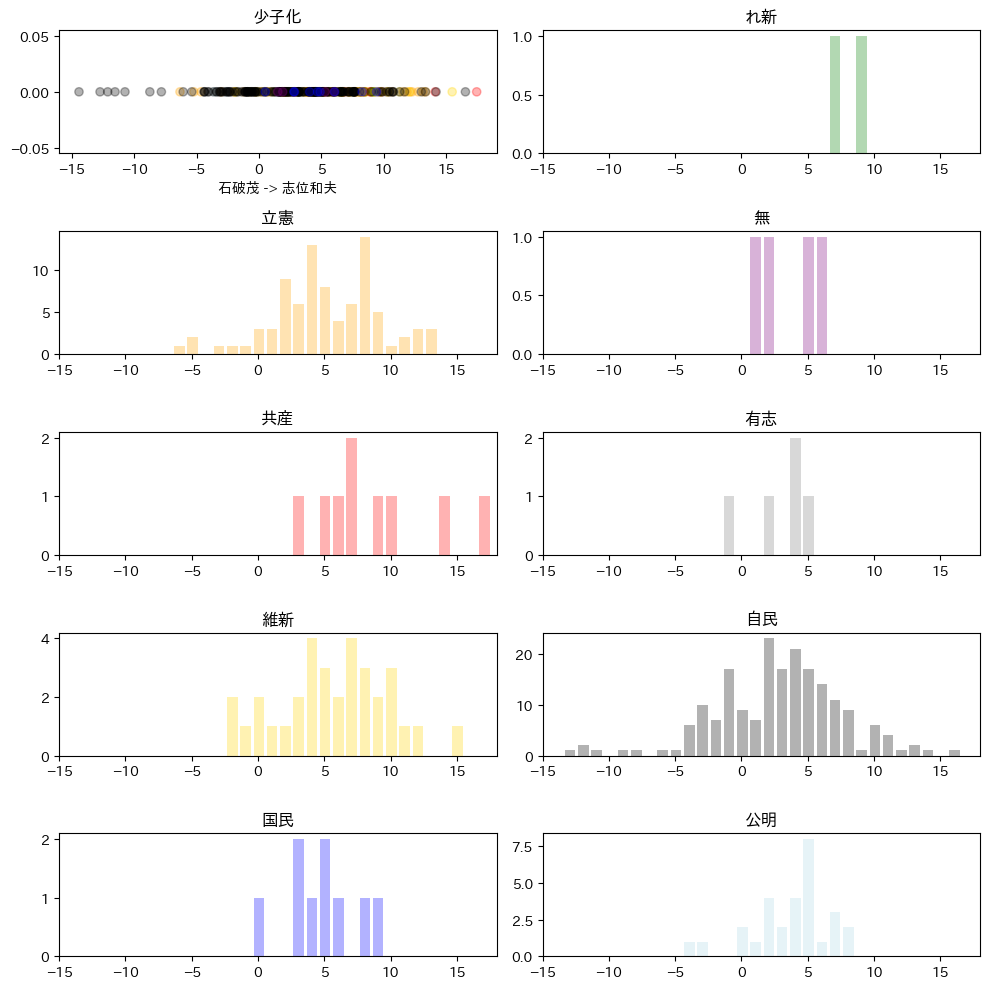

In [32]:
vo = VectorOperator()
psv = PoliticalStanceVisualizer()
topic = '国債'
ref_repr1 = '岸田文雄'
ref_repr2 = '野田佳彦'
projections, reprs = vo.collapse_vectors_onto_two_ref_reprs(summary_hdf5_path = os.path.join(DATA_REPR_SPEECHES_DIR, f'{topic}.hdf5'),
															topic=topic,
															ref_repr1=ref_repr1,
															ref_repr2=ref_repr2)
parties = [vo.embedding_handler.repr2party[repr] for repr in reprs]

psv.visualize(xs=projections,
			  labels=reprs,
			  colors=[PARTY_TO_COLOR[party] for party in parties],
			  parties=parties,
			  title=topic,
			  xlabel=f'{ref_repr1} -> {ref_repr2}')

# Topic Modelling on Politicians 

## 1. Group politicians based on position on the axis  

In [256]:
# definitions 
    # group is the part of the axes 
    # party is the political party
    # rep is the representative (i.e., politician name)

# a. Divide the axis into n parts
n = 3

axis_range = np.max(projections) - np.min(projections) # TODO: possibly re-adjust the range to reflect the range in the viz?
portion_size = axis_range / n
dividing_points = [np.min(projections) + i * portion_size for i in range(1, 3)]

# b. Group politicians based on their position on the axis 
groups = np.digitize(projections, dividing_points)

# c. Add politician and party to dict # group 1, 2, 3 (from left to right)
group_dict = {group_num: {'politicians': [], 'parties': set()} for group_num in range(1, 4)}

for rep, group, party in zip(reprs, groups, parties):
    group_dict[group + 1]['politicians'].append(rep) # added +1 because of zero indexing 
    group_dict[group + 1]['parties'].add(party)

group_dict

{1: {'politicians': ['谷田川元',
   '松木けんこう',
   '末松義規',
   '細田健一',
   '金子恭之',
   '柴山昌彦',
   'あかま二郎',
   '高木毅',
   '武藤容治',
   '大塚拓',
   '長島昭久',
   '小林鷹之',
   '渡辺孝一',
   '齋藤健',
   '今村雅弘',
   '松本洋平',
   '浜田靖一'],
  'parties': {'立憲', '自民'}},
 2: {'politicians': ['斉藤鉄夫',
   '佐藤茂樹',
   '浮島智子',
   '佐藤英道',
   '日下正喜',
   '吉田宣弘',
   '吉田久美子',
   '岡本三成',
   '輿水恵一',
   '角田秀穂',
   '大口善徳',
   '浜地雅一',
   '石井啓一',
   '鰐淵洋子',
   '竹内譲',
   '中野洋昌',
   '中川康洋',
   '赤羽一嘉',
   '伊佐進一',
   '稲津久',
   '平林晃',
   '高木陽介',
   '中川宏昌',
   '山崎正恭',
   '北側一雄',
   '玄葉光一郎',
   '白石洋一',
   '大串博志',
   '牧義夫',
   '梅谷守',
   '江田憲司',
   '大河原まさこ',
   '小熊慎司',
   '中谷一馬',
   '緑川貴士',
   '重徳和彦',
   '城井崇',
   '馬淵澄夫',
   '後藤祐一',
   '篠原豪',
   '渡辺周',
   '坂本祐之輔',
   '柚木道義',
   '小宮山泰子',
   '下条みつ',
   '西村智奈美',
   '伴野豊',
   '福田昭夫',
   '田嶋要',
   '末次精一',
   '小沢一郎',
   '野田佳彦',
   '石川香織',
   '菅直人',
   '湯原俊二',
   '吉川元',
   '山井和則',
   '大島敦',
   '森山浩行',
   '長妻昭',
   '鎌田さゆり',
   '青山大人',
   '安住淳',
   '中島克仁',
   '森田俊和',
   '佐藤公治',
   '青柳陽一郎',
   '枝野幸男',
   '奥野

## 2. Get the opinion sentences of each group on the axes

In [188]:
from bertopic import BERTopic

topic = '少子化'

def text_preprocessing(texts):
    processed_texts = []
    for text in texts:
        # remove specific characters using re.sub
        text = re.sub('[、\r\n\u3000]', '', text)
        processed_texts.append(text)
    return processed_texts

group_topics = {}
group_dict_2 = group_dict.copy() # copy because cannot change size while we iterate

for group_num, group_info in group_dict.items():
    opinion_sentences = []
    
    for politician in group_info['politicians']:
        embeddings, dates, opinions = eh.get_embeddings_for_repr_for_topic(politician, topic)
        opinion_sentences.extend(opinions)

    #preprocess
    preprocessed_opinions = text_preprocessing(opinion_sentences)
    group_dict_2[group_num]['opinions_text'] = preprocessed_opinions

## 3. Topic Model

### BERTopic

In [258]:
# TODO: fixing stopwords to get rid of unwanted common ideas

import MeCab
from sklearn.feature_extraction.text import CountVectorizer

mecab = MeCab.Tagger('-Owakati')

def tokenize_jp(text):
    text = re.sub('[、\r\n\u3000]', '', text)

    # Read stopwords from file
    with open('stopwords-ja.txt', encoding='utf-8') as f:
        stopwords = set(f.read().split())
    
    words = MeCab.Tagger("-Owakati").parse(text).split()
    
    # Remove stopwords from words
    words = [w for w in words if w not in stopwords] # TODO: find a comprehensive list of jp stopwords to make sure we get more sensical topic outputs
    
    return words

## test tockenizer 
# test = "今後も言語モデルの発展に伴って付け替え可能。文書のクラスタリングUMAPで次元削減した後、 HDBSCANでクラスタリング。次元削減手法やクラスタリング手法も付け替え可能。"
# tokenize_jp(test)

def apply_bertopic(group_dict: dict, group_num: int, nr_topics: int): # "cl-tohoku/bert-base-japanese-v3" has sentence embeddings as st
    MODEL_NAME = st #"sentence-transformers/paraphrase-multilingual-mpnet-base-v2"  # smaller model: "paraphrase-multilingual-MiniLM-L12-v2"
    vectorizer_model = CountVectorizer(tokenizer=tokenize_jp)
    model = BERTopic(verbose="True", embedding_model=MODEL_NAME, nr_topics=nr_topics, vectorizer_model=vectorizer_model) 
    
    topics, probs  = model.fit_transform(group_dict[group_num]['opinions_text'])
    
    return model

group_1 = apply_bertopic(group_dict_2, 1, 10)
# group_2 = apply_bertopic(2, 10)
# group_3 = apply_bertopic(3, 10)

Batches: 100%|██████████| 8/8 [01:40<00:00, 12.61s/it]
2023-11-30 19:00:10,012 - BERTopic - Transformed documents to Embeddings
2023-11-30 19:00:11,713 - BERTopic - Reduced dimensionality
2023-11-30 19:00:11,730 - BERTopic - Clustered reduced embeddings
2023-11-30 19:00:11,844 - BERTopic - Reduced number of topics from 7 to 7


In [259]:
display(group_1.get_topic_info())
# display(group_2.get_topic_info())
# display(group_3.get_topic_info())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,61,-1_化_学校_教育_考え,"[化, 学校, 教育, 考え, 等, 少子, 中, 重要, 日本, 大学]",[○柴山国務大臣今委員が御指摘になられたとおり少子化が今後更に進展をしていくことによって学校...
1,0,44,0_大学_等_進学_教育,"[大学, 等, 進学, 教育, 考え, 化, 所得, 子供, 社会, 必要]",[次に少子化の進展への対処にどのように寄与するのか具体的な目算や目標値等はあるのかなぜ授業料...
2,1,33,1_支援_大学_考え_案,"[支援, 大学, 考え, 案, 金, つい, 今回, 者, 奨学, 法]",[いずれにいたしましても文部科学省としてはこの新たな制度により真に支援が必要な学生に対し確実...
3,2,18,2_文化_研究_改革_教育,"[文化, 研究, 改革, 教育, 大学, 芸術, イニシアティブ, 高等, まいり, 連携]",[このような観点から先日高等教育・研究改革イニシアティブ柴山イニシアティブを発表したところで...
4,3,34,3_そう_あるいは_ふう_やはり,"[そう, あるいは, ふう, やはり, いっ, まし, じゃ, いく, ござい, もう]",[ですからそういう状況を踏まえたときにもうちょっと政府としてあるいは総務省としてしっかり国の...
5,4,11,4_党_御_国民_政党,"[党, 御, 国民, 政党, 問題, とおり, 方々, 府, 考え, つい]",[しかし先ほど申し上げたとおり一定の問題点については喫緊の改正の課題として全国民的合意を得ら...
6,5,39,5_思い_そう_けれど_ござい,"[思い, そう, けれど, ござい, ふう, まし, 地方, 中, 大変, 思っ]",[そういうところがやっぱりちょっと違うんじゃないかなというふうに思っておりましてまたいろんな...


In [249]:
group_1.visualize_barchart(n_words=10)
# group_1.visualize_topics()
# group_1.get_topics()
# group_1.get_topic(3)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03604853843719889, 0.03748194361491471,
                    0.037884585758588905, 0.03812914866308834,
                    0.040035768699138115, 0.0409525597905248, 0.04131612723085087,
                    0.04446415763880185, 0.052537765395658825, 0.05639918411213384],
              'xaxis': 'x',
              'y': [いく  , あるいは  , ござい  , けれど  , 思い  , いっ  , 化  , 中  , まし  , そう  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.035641063943536125, 0.03989250377067592,
                    0.04126452024559768, 0.048122401515959944, 0.05390821558487618,
                    0.05816267624501129, 0.058345262710396244, 0.06789632929761096,
                    0.07578744279840585, 0.09094479031639104],
              'xaxis': 'x2',
              'y': [必要  , つい  , 進学  , 学校  , 支援  , 化  , 等  , 考え  , 教育  , 大学  ],
              'yaxis': 'y2'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 325.0,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': 'Topic Word Scores',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.175], 'showgrid': True},
               'xaxis2': {'anchor': 'y2', 'domain': [0.275, 0.45], 'showgrid': True},
               'xaxis3': {'anchor': 'y3', 'domain': [0.55, 0.7250000000000001], 'showgrid': True},
               'xaxis4': {'anchor': 'y4', 'domain': [0.825, 1.0], 'showgrid': True},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'showgrid': True},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 1.0], 'showgrid': True},
               'yaxis3': {'anchor': 'x3', 'domain': [0.0, 1.0], 'showgrid': True},
               'yaxis4': {'anchor': 'x4', 'domain': [0.0, 1.0], 'showgrid': True}}
})

### LDA (would need fixing)

In [260]:
# import re 
# from sklearn.decomposition import LatentDirichletAllocation
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import make_pipeline

# topic = '少子化'

# num_topics = 5 


# mecab = MeCab.Tagger('-Owakati')
# def tokenize_jp(text):
#     text = re.sub('[、\r\n\u3000]', '', text)

#     # Read stopwords from file
#     with open('stopwords-ja.txt', encoding='utf-8') as f:
#         stopwords = set(f.read().split())
    
#     words = MeCab.Tagger("-Owakati").parse(text).split()
    
#     # Remove stopwords from words
#     words = [w for w in words if w not in stopwords]
    
#     return words


# lda_model = make_pipeline(CountVectorizer(analyzer=tokenize_jp), LatentDirichletAllocation(n_components=num_topics, random_state=42))

# group_topics = {}

# # retrieve opinion sentences
# for group_num, group_info in group_dict.items():
#     opinion_sentences = []
    
#     for politician in group_info['politicians']:
#         embeddings, dates, opinions = eh.get_embeddings_for_repr_for_topic(politician, '少子化')
#         opinion_sentences.extend(opinions)

#     # fit LDA on the opinion sentences
#     lda_model.fit(opinion_sentences)
    
#     # get topics and their associated words
#     feature_names = lda_model.named_steps['countvectorizer'].get_feature_names_out()
#     topics = []
#     for topic_idx, topic in enumerate(lda_model.named_steps['latentdirichletallocation'].components_):
#         topic_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
#         topics.append(topic_words)
    
#     group_topics[group_num] = topics

In [251]:
group_topics

{1: [['考え', 'つい', '大学', '化', '御', 'たい', 'まし', 'けれど', '改革', '少子'],
  ['教育', '考え', '化', '大学', '少子', '支援', '経済', '進学', '等', 'まし'],
  ['地域', '大学', '社会', '省', '地方', '等', '連携', '支援', '科学', '国'],
  ['中', 'そう', 'いっ', '人', '日本', '国', '学校', 'いく', 'まし', 'つい'],
  ['化', '考え', '学校', '等', '教育', '大学', '文化', 'つい', '必要', '強化']],
 2: [['そう', '思い', 'けれど', '化', '思っ', 'ふう', 'やはり', 'まし', '少子', '今'],
  ['社会', '考え', '制度', '子供', '負担', 'いく', '経済', '保障', '世代', 'つい'],
  ['国民', '法', '党', '案', 'ませ', 'つい', '改革', '政府', '考え', 'べき'],
  ['年', '一', '二', 'ませ', '円', '五', '三', 'まし', '大臣', '〇'],
  ['化', '考え', '支援', '対策', '少子', 'まいり', '重要', '等', '地域', '社会']],
 3: [['化', '少子', '対策', '社会', '思い', '日本', '一', '国', '問題', 'ませ'],
  ['国会', '党', '国民', 'ませ', 'べき', '思い', '議論', 'まし', '会', '民主'],
  ['ませ', 'べき', '国民', '総理', '防衛', '内閣', 'す', '予算', '考え', 'でしょう'],
  ['思い', '子供', 'たい', 'ませ', 'そう', '方', 'けれど', '子育て', 'まし', '化'],
  ['考え', '思い', 'そう', 'ふう', 'こう', '地方', 'いく', '国', '政策', 'べき']]}